In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

trivial PR_T

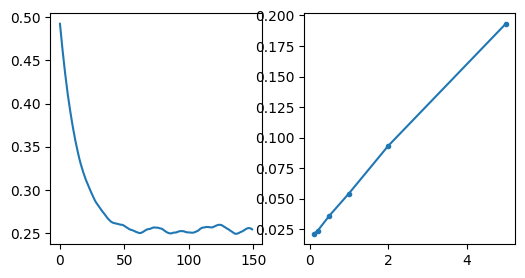

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 50
flip_n = 20
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.asarray([0.1, 0.2,0.5,1,2,5])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')

h_acov

In [3]:
def num_primitive_fct(num_function, baseline_idx, x_resolution, axis =-1):
  sum_left = jnp.cumsum(num_function, axis = axis) / x_resolution
  sum_right = jnp.cumsum(-num_function[..., ::-1], axis = axis)[..., ::-1] / x_resolution
  mean_sum = (sum_left + sum_right) / 2
  return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def num_integral_fct(num_function, x_resolution, axis =-1):
  sum_left = jnp.sum(num_function[..., :-1], axis = axis) / x_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = axis) / x_resolution
  return((sum_left + sum_right) / 2)

In [4]:
#parameters for numerics
interval_len = 10
long_interval_len = 10 * interval_len
x_resolution = 100

zero_x_idx = int(interval_len / 2 * x_resolution)
x_idx_s = jnp.arange(interval_len * x_resolution)
x_s = x_idx_s / x_resolution - interval_len / 2

sta_gau_s = 1/jnp.sqrt(2*jnp.pi) * jnp.exp(- x_s ** 2 /2)
def sta_gau_fct(x):
  return(jnp.interp(x, x_s, sta_gau_s, left = 0, right = 0))
tanh_pri_s = num_primitive_fct(jnp.tanh(x_s), zero_x_idx, x_resolution)
def tanh_pri_fct(x):
  return(jnp.interp(x, x_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))

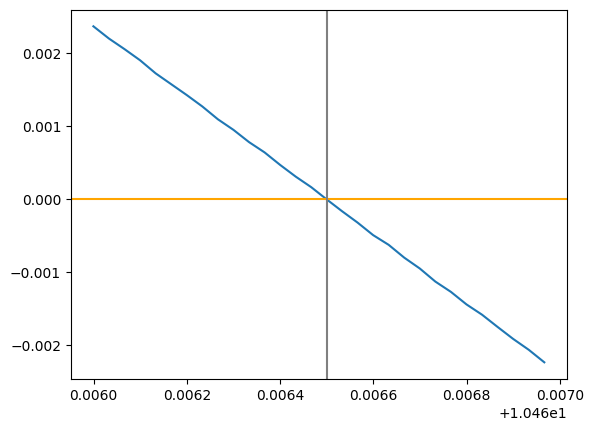

In [5]:
# determine stable init_h_acov
unscaled_std = 4.#1.9

# # phi(gh)
# init_h_acov_s_interval = jnp.asarray([0.6535,0.6545])
# init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
# init_potential_s = (-(init_h_acov_s ** 2 / 2)
#  +num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
#                                * sta_gau_fct(x_s), 
#                                      x_resolution) / unscaled_std ** 2 
#  -num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
#                                * sta_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2)
# init_h_acov = 0.65415#0.45903

# g phi
init_h_acov_s_interval = jnp.asarray([10.466,10.467])
init_h_acov_s = init_h_acov_s_interval[0]+jnp.arange(30)/30*(init_h_acov_s_interval[1]-init_h_acov_s_interval[0])
init_potential_s = (-(init_h_acov_s ** 2 / 2)
 +num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1))) **2
                               * sta_gau_fct(x_s), 
                                     x_resolution) * unscaled_std ** 2 
 -num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(jnp.expand_dims(init_h_acov_s, 1)))
                               * sta_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2)
init_h_acov = 10.4665#1.65712

plt.plot(init_h_acov_s, init_potential_s)
plt.axhline(y = 0, color = 'orange')
plt.axvline(x = init_h_acov, color = 'gray')

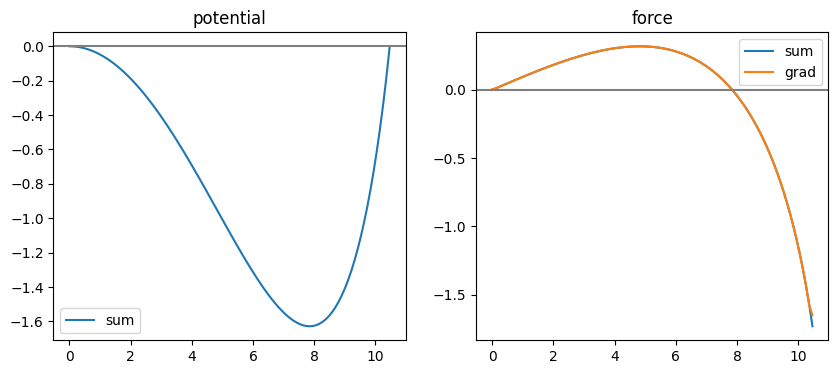

In [6]:
h_acov_step_n = x_resolution
h_acov_idx_s = jnp.arange(h_acov_step_n + 1)
h_acov_s = h_acov_idx_s / h_acov_step_n * init_h_acov

# # phi(g h)
# potential_s_1 = -(h_acov_s ** 2 / 2)
# potential_s_2 = num_integral_fct(
#     num_integral_fct(tanh_pri_fct(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                                   + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(sta_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(sta_gau_fct(x_s), 0),
#     x_resolution) / unscaled_std ** 2
# potential_s_3 = -num_integral_fct(tanh_pri_fct(unscaled_std * x_s * jnp.sqrt(init_h_acov))
#                                * sta_gau_fct(x_s), 
#                                      x_resolution) **2 / unscaled_std ** 2
# force_s_1 = h_acov_s 
# force_s_2 = -num_integral_fct(
#     num_integral_fct(jnp.tanh(unscaled_std * jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
#                               + unscaled_std * jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
#                  * jnp.expand_dims(sta_gau_fct(x_s), (0, 1)), 
#                  x_resolution) ** 2
#     * jnp.expand_dims(sta_gau_fct(x_s), 0),
#     x_resolution)

# g phi(h)
potential_s_1 = -(h_acov_s ** 2 / 2)
potential_s_2 = num_integral_fct(
    num_integral_fct(tanh_pri_fct(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(sta_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(sta_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2
potential_s_3 = -num_integral_fct(tanh_pri_fct(x_s * jnp.sqrt(init_h_acov))
                               * sta_gau_fct(x_s), 
                                     x_resolution) **2 * unscaled_std ** 2
force_s_1 = h_acov_s 
force_s_2 = -num_integral_fct(
    num_integral_fct(jnp.tanh(jnp.expand_dims(x_s, (0, 1)) * jnp.sqrt(init_h_acov - jnp.expand_dims(h_acov_s, (1, 2))) 
                                        + jnp.expand_dims(x_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
                 * jnp.expand_dims(sta_gau_fct(x_s), (0, 1)), 
                 x_resolution) ** 2
    * jnp.expand_dims(sta_gau_fct(x_s), 0),
    x_resolution) * unscaled_std ** 2

potential_s = potential_s_1 + potential_s_2 + potential_s_3
potential_s = potential_s - potential_s[0]
force_s = force_s_1 + force_s_2

[fig, subfig_s] = plt.subplots(1, 2, figsize = (10,4), squeeze = False)
subfig_s[0, 0].title.set_text("potential")
subfig_s[0, 1].title.set_text("force")
subfig_s[0, 0].plot(h_acov_s, potential_s, label = "sum")
#subfig_s[0, 0].plot(h_acov_s, potential_s_1, label = "^2")
#subfig_s[0, 0].plot(h_acov_s, potential_s_2, label = "itg")
#subfig_s[0, 0].plot(h_acov_s, jnp.full(h_acov_s.shape, potential_s_3), label = "c")
subfig_s[0, 1].plot(h_acov_s, force_s, label = "sum")
subfig_s[0, 1].plot(h_acov_s, -jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, label = "grad")
#subfig_s[0, 1].plot(h_acov_s, force_s_1, label = "^1")
#subfig_s[0, 1].plot(h_acov_s, force_s_2, label = "itg")
subfig_s[0, 0].axhline(y = 0, color = 'gray')
subfig_s[0, 1].axhline(y = 0, color = 'gray')
subfig_s[0, 0].legend()
subfig_s[0, 1].legend()

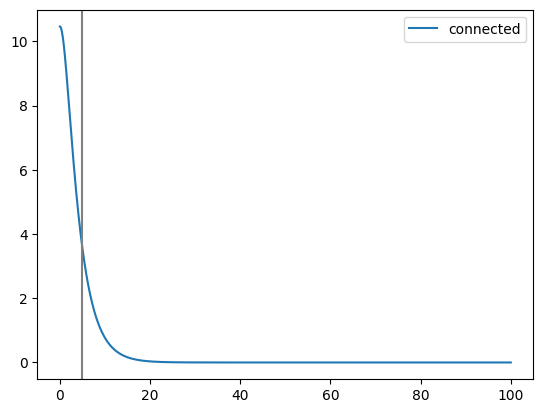

In [7]:
sim_len = 100 # affects f_max and leads to a neg error in ccov baseline
sim_resolution = 30
connection_pos = 5 #2d to 1d

cov_lag_s = jnp.arange(sim_len * sim_resolution + 1)/sim_resolution
sim_interval_2d = jnp.asarray([0, connection_pos])
sim_interval_1d = jnp.asarray([connection_pos, sim_len])

def h_acov_2d_velocity_fct(pos_vel):
  return(jnp.asarray([pos_vel[1], jnp.interp(pos_vel[0], h_acov_s,-jnp.gradient(potential_s) * h_acov_step_n/init_h_acov, 
                                             left = 0, right = "extrapolate")]))
def h_acov_1d_velocity_fct(h_acov):
  return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2*potential_s, 0)), 
                    left = 0, right = "extrapolate"))

h_acov_traj_c_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval_2d, sim_resolution)
h_acov_traj_c_2d = rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_c_2d, sim_interval_2d[0], sim_resolution)
h_acov_traj_c_1d = traj_initializer(jnp.asarray(h_acov_traj_c_2d[0,-1]), sim_interval_1d, sim_resolution)
h_acov_traj_c_1d = rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_c_1d, sim_interval_1d[0], sim_resolution)
h_acov_traj_c = jnp.concatenate([jnp.asarray([init_h_acov]), h_acov_traj_c_2d[0], h_acov_traj_c_1d])

# # if done using 1d/2d independently
# sim_interval_full = jnp.asarray([0,sim_len])
# h_acov_traj_1d = traj_initializer(jnp.asarray(init_h_acov-0.00001), sim_interval_full, sim_resolution)
# h_acov_traj_1d = jnp.insert(rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_traj_1d, sim_interval_full[0], sim_resolution), 
#                           0, init_h_acov)
# h_acov_traj_2d = traj_initializer(jnp.asarray([init_h_acov, 0]), sim_interval_full, sim_resolution)
# h_acov_traj_2d = jnp.insert(rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_traj_2d, sim_interval_full[0], sim_resolution),
#                           0, jnp.asarray([init_h_acov, 0]), axis = 1)

# plt.plot(cov_lag_s, h_acov_traj_1d, label = "1d")
# plt.plot(cov_lag_s, h_acov_traj_2d[0], label = "2d")
plt.plot(cov_lag_s, h_acov_traj_c, label = "connected")
plt.axvline(x = connection_pos, color = 'gray')
plt.legend()

ft, r_acov and ccov

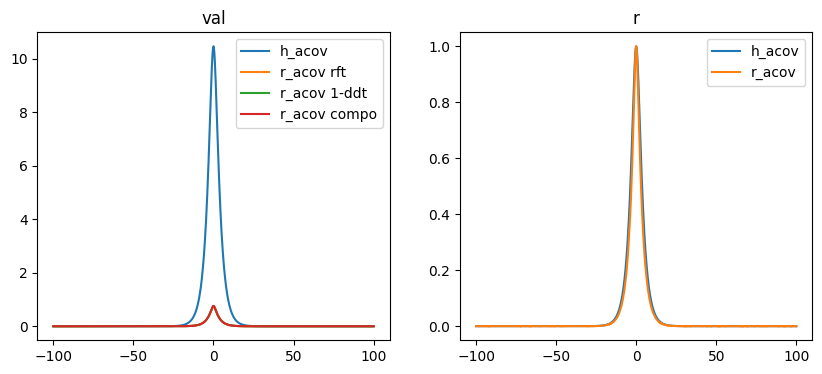

In [8]:
def mirror(traj, transformation = lambda x:x): # only positive tau leads to huge ringings
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), 
                          traj], axis = -1))

h_acov_traj_mirrored = mirror(h_acov_traj_c)
cov_lag_s_mirrored = mirror(cov_lag_s, lambda x:-x)
zero_lag_idx = sim_len * sim_resolution + 1

# r_acov
ft_n = sim_len * sim_resolution * 2 + 1
rft_n = jnp.ceil((ft_n + 1)/2).astype(int) # rft is fine since only 1d
rft_omega_s = 2 * jnp.pi * jnp.arange(rft_n)  / (2*sim_len)
r_acov_traj_rft = jnp.fft.rfft(h_acov_traj_mirrored) * (1+ rft_omega_s**2) / unscaled_std ** 2
r_acov_traj_mirrored = jnp.fft.irfft(r_acov_traj_rft, n=ft_n)

[fig, subfig_s] = plt.subplots(1, 2, figsize = (10,4), squeeze = False)
subfig_s[0, 0].title.set_text("val")
subfig_s[0, 1].title.set_text("r")
subfig_s[0, 0].plot(cov_lag_s_mirrored, h_acov_traj_mirrored, label = "h_acov")
subfig_s[0, 0].plot(cov_lag_s_mirrored, r_acov_traj_mirrored, label = "r_acov rft")
subfig_s[0, 0].plot(cov_lag_s_mirrored, (h_acov_traj_mirrored - jnp.gradient(jnp.gradient(h_acov_traj_mirrored)) * sim_resolution **2)/ unscaled_std ** 2, label = "r_acov 1-ddt")
subfig_s[0, 0].plot(cov_lag_s_mirrored, jnp.interp(h_acov_traj_mirrored, h_acov_s, -force_s_2 / unscaled_std ** 2, left = 0), label="r_acov compo")
subfig_s[0, 0].legend()
subfig_s[0, 1].plot(cov_lag_s_mirrored, h_acov_traj_mirrored/h_acov_traj_mirrored[zero_lag_idx], label = "h_acov")
subfig_s[0, 1].plot(cov_lag_s_mirrored, r_acov_traj_mirrored/r_acov_traj_mirrored[zero_lag_idx], label = "r_acov")
subfig_s[0, 1].legend()

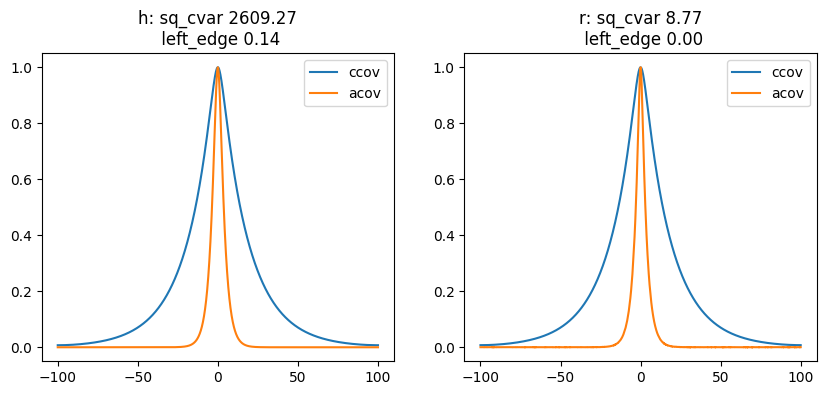

In [9]:
tanh_der_s = jnp.gradient(jnp.tanh(x_s))*x_resolution
def tanh_der_fct(x):
  return(jnp.interp(x, x_s, tanh_der_s, left = "extrapolate", right = "extrapolate"))

#ccov_sq # should not use rft since eventually 2d
ft_omega_s = jnp.concatenate([rft_omega_s, -(rft_omega_s[..., 1:][..., ::-1])])
h_acov_traj_ft = jnp.fft.fft(h_acov_traj_mirrored)
r_acov_traj_ft = h_acov_traj_ft * (1+ ft_omega_s**2) / unscaled_std ** 2
temp_xx_s = (1+jax.lax.complex(0.,jnp.expand_dims(ft_omega_s,1)))*(1+jax.lax.complex(0.,jnp.expand_dims(ft_omega_s,0)))
mean_gain = num_integral_fct(tanh_der_fct(jnp.sqrt(init_h_acov) * x_s) * sta_gau_fct(x_s), x_resolution)

h_ccov_sq = jnp.fft.ifft2(
  ((2*jnp.abs(temp_xx_s)**2 - unscaled_std**4 * mean_gain**4)/jnp.abs(temp_xx_s-unscaled_std**2 * mean_gain**2)**2-1)
  *jnp.expand_dims(h_acov_traj_ft, 1)*jnp.expand_dims(h_acov_traj_ft, 0),
  (ft_n,ft_n)) #rfft2 is false, see rfft2 doc
h_ccov_sq = jnp.real(h_ccov_sq)
r_ccov_sq = jnp.fft.ifft2(
  (jnp.abs(temp_xx_s/(temp_xx_s-unscaled_std**2 * mean_gain**2))**2-1)
  *jnp.expand_dims(r_acov_traj_ft, 1)*jnp.expand_dims(r_acov_traj_ft, 0),
  (ft_n,ft_n)) #rfft2 is false, see rfft2 doc
r_ccov_sq = jnp.real(r_ccov_sq)

[fig, subfig_s] = plt.subplots(1, 2, figsize = (10,4), squeeze = False)
subfig_s[0, 0].title.set_text("h: sq_cvar {0:.2f}\n left_edge {1:.2f}".format(h_ccov_sq[zero_lag_idx,zero_lag_idx], h_ccov_sq[0,0]))
subfig_s[0, 1].title.set_text("r: sq_cvar {0:.2f}\n left_edge {1:.2f}".format(r_ccov_sq[zero_lag_idx,zero_lag_idx], r_ccov_sq[0,0]))
subfig_s[0, 0].plot(cov_lag_s_mirrored,jnp.sqrt(jnp.einsum("ii->i",h_ccov_sq)/h_ccov_sq[zero_lag_idx,zero_lag_idx]), label= "ccov")
subfig_s[0, 0].plot(cov_lag_s_mirrored,h_acov_traj_mirrored/h_acov_traj_mirrored[zero_lag_idx], label = "acov")
subfig_s[0, 1].plot(cov_lag_s_mirrored,jnp.sqrt(jnp.einsum("ii->i",r_ccov_sq)/r_ccov_sq[zero_lag_idx,zero_lag_idx]), label= "ccov")
subfig_s[0, 1].plot(cov_lag_s_mirrored,r_acov_traj_mirrored/r_acov_traj_mirrored[zero_lag_idx], label = "acov")
subfig_s[0, 0].legend()
subfig_s[0, 1].legend()

pr_T

In [10]:
part_n = 1000
window_len_s = jnp.asarray([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])

pr_lag_len = jnp.round(window_len_s[-1]* 2.5).astype(int)
pr_lag_s = jnp.arange(- pr_lag_len * x_resolution, pr_lag_len * x_resolution) / x_resolution
zero_pr_lag_idx = pr_lag_len * x_resolution

#verify length is enough for filters
std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
num_integral_fct(sta_gau_fct(pr_lag_s/std_s)/std_s, x_resolution)

Array([0.99999934, 0.99999934, 0.99999946, 0.9999994 , 0.99999946,
       0.99999946, 0.99999946, 0.9999994 , 0.999593  ], dtype=float32)

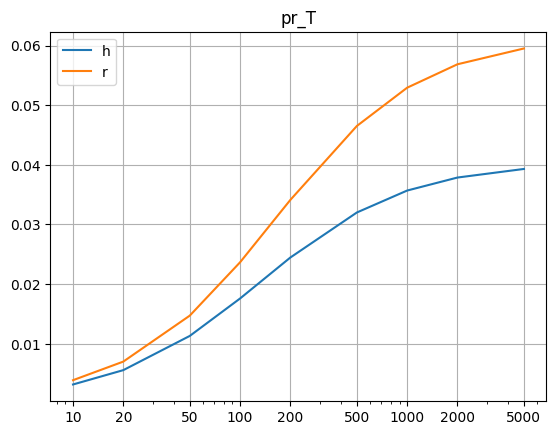

In [32]:
# turn to functions # avoid running for longer lens just to allow larger windows 
def h_acov_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, h_acov_traj_mirrored, left = 0, right = 0))
def h_ccov_sq_main_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, jnp.einsum("ii->i",h_ccov_sq), left = 0, right = 0))
def h_ccov_sq_off_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, jnp.einsum("ii->i",h_ccov_sq[:,::-1]), left = 0, right = 0))
def r_acov_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, r_acov_traj_mirrored, left = 0, right = 0))
def r_ccov_sq_main_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, jnp.einsum("ii->i",r_ccov_sq), left = 0, right = 0))
def r_ccov_sq_off_fct(x):
  return(jnp.interp(x, cov_lag_s_mirrored, jnp.einsum("ii->i",r_ccov_sq[:,::-1]), left = 0, right = 0))

# cvar_sqs
def local_cvar_sq_iiii_fct(acov_fct, window_len_s, pr_lag_s, resolution):
  std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
  return(acov_fct(0) ** 2 
         + num_integral_fct(2* acov_fct(pr_lag_s) **2 
                            * sta_gau_fct(pr_lag_s/std_s)/std_s, 
                            resolution))
def local_cvar_sq_iijj_fct(acov_fct, ccov_sq_main_fct, part_n, window_len_s, pr_lag_s, resolution):
  std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
  return(acov_fct(0) ** 2 
         + num_integral_fct(2/part_n* ccov_sq_main_fct(pr_lag_s)
                            * sta_gau_fct(pr_lag_s/std_s)/std_s, 
                            resolution))
def local_cvar_sq_ijij_fct(acov_fct, ccov_sq_off_fct, part_n, window_len_s, pr_lag_s, resolution):
  std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
  return(ccov_sq_off_fct(0) / part_n
         + num_integral_fct((acov_fct(pr_lag_s) **2 + ccov_sq_off_fct(pr_lag_s) / part_n)
                            * sta_gau_fct(pr_lag_s/std_s)/std_s, 
                            resolution))
def pr_s(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct, part_n, window_len_s, pr_lag_s, resolution):
  local_cvar_sq_iiii = local_cvar_sq_iiii_fct(acov_fct, window_len_s, pr_lag_s, resolution)
  local_cvar_sq_iijj = local_cvar_sq_iijj_fct(acov_fct, ccov_sq_main_fct, part_n, window_len_s, pr_lag_s, resolution)
  local_cvar_sq_ijij = local_cvar_sq_ijij_fct(acov_fct, ccov_sq_off_fct, part_n, window_len_s, pr_lag_s, resolution)
  return((local_cvar_sq_iiii + (part_n - 1)*local_cvar_sq_iijj) 
         / (part_n * local_cvar_sq_iiii + part_n * (part_n - 1) * local_cvar_sq_ijij))

h_pr_s = pr_s(h_acov_fct, h_ccov_sq_main_fct, h_ccov_sq_off_fct, part_n, window_len_s, pr_lag_s, x_resolution)
r_pr_s = pr_s(r_acov_fct, r_ccov_sq_main_fct, r_ccov_sq_off_fct, part_n, window_len_s, pr_lag_s, x_resolution)

plt.title("pr_T")
plt.plot(window_len_s, h_pr_s, label = "h")
plt.plot(window_len_s, r_pr_s, label = "r")
plt.xscale("log")
plt.xticks(window_len_s, labels = window_len_s)
plt.grid()
plt.legend()

In [ ]:
sleep

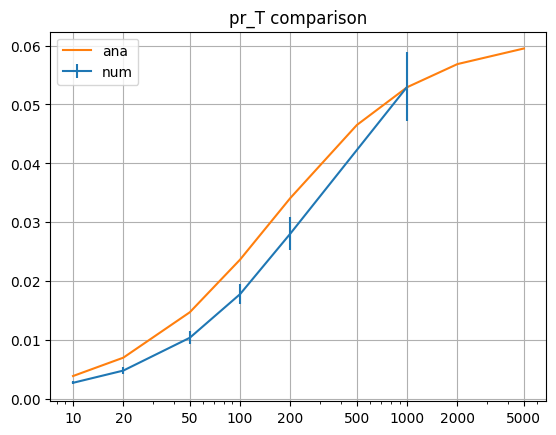

In [34]:
#compare (kernal order is 2 for ana but inf for num)
[plot_window_len_s, num_r_pr_s] = load_as_list("1000_free_pr.npz")

plt.title("pr_T comparison")
plt.errorbar(plot_window_len_s, num_r_pr_s[0], yerr=num_r_pr_s[1], label = "num")
plt.plot(window_len_s, r_pr_s, label = "ana")
plt.xscale("log")
plt.xticks(window_len_s, labels = window_len_s)
plt.grid()
plt.legend()